### Author: Kenneth Zhang

## Semantic Segmentation for Aerial Drone Dataset (Research Group 2)

### Semantic image segmentation is a branch of computer vision and its goal is to label each pixel of an image with a corresponding class of what is being represented. The output in semantic  segmentation is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. It is a pixel level image classification.

## Examples of the applications of this task are:
### Autonomous vehicles, where semantic segmentation provides information about free space on the roads, as well as to detect lane markings and traffic signs. Biomedical image diagnosis,  helping radiologists improving analysis performed, greatly reducing the time required to run diagnostic tests. Geo sensing, to recognize the type of land cover (e.g., areas of urban,  agriculture, water, etc.) for each pixel on a satellite image, land cover classification can be regarded as a multi-class semantic segmentation task.

## U-Net Convolutional architecture (FCN-Variant):
### U-Net is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.  The architecture of a U-Net contains two paths: the first one is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a   traditional stack of convolutional and max pooling layers; the second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using  transposed convolutions. In the original paper, the U-Net is described as follows:

<img src = "https://miro.medium.com/max/3000/1*OkUrpDD6I0FpugA_bbYBJQ.png" width = 600px/>

In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers, initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import PIL 
from PIL import Image
import os

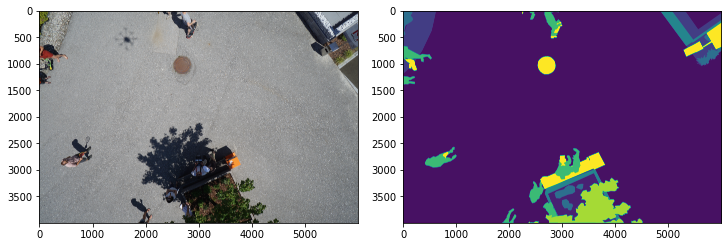

In [2]:
data_path1 = "C:/Users/kzhan/Desktop/Aerial Drone Seg/dataset/semantic_drone_dataset"
semantic_images = os.path.join(data_path1 + "/label_images_semantic")
original_images = os.path.join(data_path1 + "/original_images")
label_images = os.path.join("C:/Users/kzhan/Desktop/Aerial Drone Seg/RGB_color_image_masks/RGB_color_image_masks")

sample_original = os.path.join(original_images + "/000.jpg")
sample_semantic = os.path.join(semantic_images + "/000.png")

fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
axs[0].imshow(Image.open(sample_original))
axs[1].imshow(Image.open(sample_semantic))

In [3]:
print("No. of images =",len(os.listdir(original_images)))
print("No. of image masks =",len(os.listdir(semantic_images)))
print("No. of image labels =", len(os.listdir(label_images)))

No. of images = 400
No. of image masks = 400
No. of image labels = 400


In [4]:
import re

def sorted_alphanum(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key = alphanum_key)

In [5]:
def load_images_masks(path_images,path_masks):
    images = os.listdir(path_images)
    masks = os.listdir(path_masks)
    images_list = []
    masks_list = []
    print(len(images))

    images2 = sorted_alphanum(images)
    masks2 = sorted_alphanum(masks)
    
    for i in images2:
        im = Image.open(path_images + i)
        im1 = np.array(im.resize((128,128)))/255
        images_list.append(im1)
 
    for i in masks2:
        mask = Image.open(path_masks + i)
        mask1 = np.array(mask.resize((128,128)))/255
        masks_list.append(mask1)
        
    return images_list,masks_list

In [6]:
original_images = os.path.join(data_path1 + "/original_images/")
label_images = os.path.join("C:/Users/kzhan/Desktop/Aerial Drone Seg/RGB_color_image_masks/RGB_color_image_masks/")

X, y = load_images_masks(original_images, label_images)

400


In [7]:
print(len(os.listdir(original_images)),len(X),len(y))
print(X[0].shape,y[0].shape)

400 400 400
(128, 128, 3) (128, 128, 3)


In [8]:
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(400, 128, 128, 3) (400, 128, 128, 3)


In [9]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

def built_unet(inputs, outputs):
    inputs = Input(shape=(128, 128, 3))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate()([u9, c1]) #removed ,axis=3
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='relu') (c9)
    return inputs, outputs

In [10]:
model = Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.summary()

NameError: name 'inputs' is not defined

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [16]:
print(X_train.shape, y_train.shape)

(320, 128, 128, 3) (320, 128, 128, 3)


In [19]:
print("There are ", X_train.shape[0], " samples for the training set.")
print("There are ", X_test.shape[0], " samples for the testing set.")

There are  320  samples for the training set.
There are  80  samples for the testing set.


In [ ]:
model.fit(X_train, y_train, epochs = 100)